In [63]:
#closed form,直接计算模型参数，以最小化损失函数为目标
#迭代寻优方法，GD:Batch GD,mini-Batch GD,SGD,迭代地改变参数以最小化损失函数
#多项式回归，以学习曲线判断是否存在过拟合，并使用正则化技术

#closed form linear regression 的特征复杂度为o(n^2.4),样本复杂度为o(m)
#线性回归模型的目标函数为凸函数
import numpy as np
np.random.seed(42)
X=2*np.random.rand(100,1)
y=4+3*X+np.random.randn(100,1)
eta=0.1
n_iterations=1000
m=100
X_b=np.c_[np.ones((100,1)),X]


theta=np.random.randn(2,1)#随机初始化
for iteration in range(n_iterations):
    gradients=2/m*X_b.T.dot(X_b.dot(theta)-y)
    theta=theta-eta*gradients

print(theta,'BGD')
from sklearn.linear_model import LinearRegression as LR
lin_reg=LR()
lin_reg.fit(X,y)
lin_reg.intercept_,lin_reg.coef_


from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(n_iter=50,penalty=None,eta0=0.1)#eta0为初始学习率，没有正则化
sgd_reg.fit(X,y.ravel())
print(sgd_reg.intercept_,sgd_reg.coef_,'SGD')

#convergence Rate O(1/iterations)
#随机梯度下降，BGD每一步都用整个训练集去计算梯度，所以对大数据不适用。而SGD在每一步随机选出
#一个样本计算梯度，因此每一次迭代都仅需在内存中存储一个样本。
#然而SGD同样有不稳定的缺点，尤其是接近最优点时，因此存在不能取得最优点的风险。但当损失函数
#不规律的情况下，这种特点会帮助算法跳过局部最小值点。
#为避免算法跳过最优值，可以逐渐减小学习率，该过程即模拟退火算法simulated annealing,
#决定每一步迭代中学习率大小的函数即learing schedule。

#模拟退火 SGD
n_epochs=50
t0,t1=5,50#learing schedule 超参数
def learning_schedule(t):
    return t0/(t+t1)
theta=np.random.randn(2,1)#2行1列的正态随机数
for epoch in range(n_epochs):
    for i in range(m):
        random_index=np.random.randint(m)#从0-m之间抽取一个整数作为初始梯度样本
        xi=X_b[random_index:random_index+1]
        yi=y[random_index:random_index+1]
        gradients=2*xi.T.dot(xi.dot(theta)-yi)#只使用一个样本，不必除以m
        eta=learning_schedule(epoch*m+i)
        theta=theta-eta*gradients

#Mini-batch Gradient Descent,利用随机选择的小样本集计算梯度，可以利用GDP进行加速计算
#参数空间较SGD更稳定，但也更易陷入局部最优



[[4.21509616]
 [2.77011339]] BGD
[4.20965338] [2.77765358] SGD


D:\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[2.81307578 7.91339535]
[1.92037885] [[0.95103815 0.50601185]]


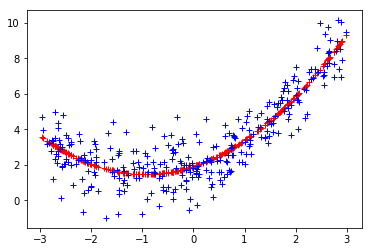

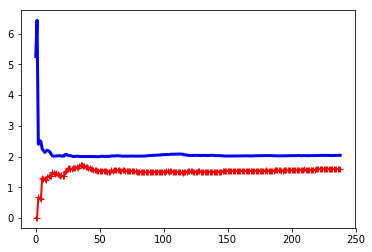

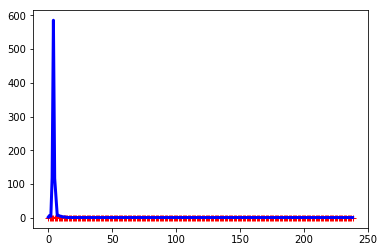

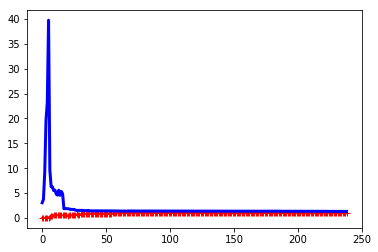

In [98]:
#多项式回归，得的features之间的关系
#np.random.seed(43)
m=300
X=6*np.random.rand(m,1)-3
y=0.5*X**2+X+2+np.random.randn(m,1)


from sklearn.preprocessing import PolynomialFeatures
poly_features=PolynomialFeatures(degree=2,include_bias=False)
X_poly=poly_features.fit_transform(X)
#经fit后，将数据去噪变为多项式型
print(X_poly[2])
lin_reg=LR()
lin_reg.fit(X_poly,y)
print(lin_reg.intercept_,lin_reg.coef_)#依次为一次项，二次项

plt.plot(X,lin_reg.predict(X_poly),'r+')
plt.plot(X,y,'b+')
plt.show()
#学习曲线,即随样本大小而变化的mse曲线
#underfitting
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split as tts

import matplotlib.pyplot as plt
import matplotlib
% matplotlib inline 
def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val=tts(X,y,test_size=0.2)
    train_errors,val_errors=[],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict=model.predict(X_train[:m])
        y_val_predict=model.predict(X_val)
        train_errors.append(mse(y_train_predict,y_train[:m]))
        val_errors.append(mse(y_val_predict,y_val))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth=2,label='train')
    plt.plot(np.sqrt(val_errors),'b-',linewidth=3,label='val')
    plt.show()
    
lin_reg=LR()
plot_learning_curves(lin_reg,X,y)

#overfitting

from sklearn.pipeline import Pipeline
poly_reg=Pipeline((
    ('poly_features',PolynomialFeatures(degree=5,include_bias=False)),
                  ('sgd_reg',LR()),
))


X_train,X_val,y_train,y_val=tts(X,y,test_size=0.2)
train_error,val_error=[],[]
for m in range(1,len(X_train)):
    X_poly_train=[]
    X_poly_val=[]
    
    poly_features=PolynomialFeatures(degree=5,include_bias=False)
    X_poly_train=poly_features.fit_transform(X_train[:m])
    
    poly_features=PolynomialFeatures(degree=5,include_bias=False)
    X_poly_val=poly_features.fit_transform(X_val)
    
    lin_reg=LR()
    lin_reg.fit(X_poly_train,y_train[:m])
    
    y_train_predict=lin_reg.predict(X_poly_train)
    y_val_predict=lin_reg.predict(X_poly_val)
    train_error.append(mse(y_train_predict,y_train[:m]))
    val_error.append(mse(y_val_predict,y_val))
plt.plot(np.sqrt(train_error),'r-+',linewidth=2,label='train')
plt.plot(np.sqrt(val_error),'b-',linewidth=3,label='val')
plt.show()
    
    

plot_learning_curves(poly_reg,X,y)
#Bias/Variance，underfitting bias高而variance低。

from sklearn.externals import joblib
joblib.dump(poly_reg,'my_model.txt')
my_model_loaded=joblib.load('my_model.txt')


In [102]:
#正则化

#岭回归、Tikhonov正则化，参数平方和正则项,L_2正则化
#岭回归对是否归一化敏感
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1,solver='cholesky')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])
sgd_reg=SGDRegressor(penalty='l2')
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

#Lasso L_1正则化，lasso易得的稀疏解
#在0附近，Lasso不可导，但可以用subgradient vector代替，
#即指定theta_i<0时，sign(theta_i)=-1;=0时，sign(\theta_i)；>0时，sign(theta)=1
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])
from sklearn.externals import joblib
joblib.dump(elastic_net,'elasticnet')

#正则化-早停，即在验证误差validation error在取得极小值点之前停止。
#在SGD和Mini-Batch，学习曲线并非光滑的，只有在validation error 高于某一最小值数次时才停止

from sklearn.base import clone
sgd_reg=SGDRegressor(warm_start=True,penalty=None,learning_rate='constant',eta0=0.005)
#warm_start=True,从上次终止的地方训练
minimum_val_error=float('inf')
best_epoch=None
best_model=None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled,y_train)
    y_val_predict=sgd_reg.predict(X_val_poly_scaled)
    val_error=mse(y_val_predict,y_val)
    if val_error<minimum_val_error:
        minimum_val_error=val_error
        best_epoch=epoch
        best_model=clone(sgd_reg)




D:\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


['elasticnet']

150


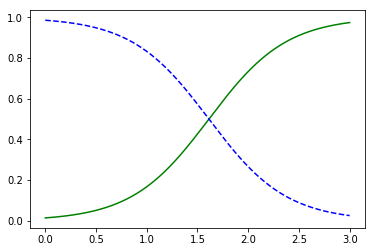

array([[3.23165998e-06, 1.10477183e-07, 9.99996658e-01]])

In [118]:
#Logitstic Regression
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())
X=iris['data'][:,3:]#只取第4个特征petal width
y=(iris['target']==2).astype(np.int)#只有Iris-Virginia=1
print(len(X))

from sklearn.linear_model import LogisticRegression as Logit
logit=Logit()
logit.fit(X,y)
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=logit.predict_proba(X_new)
plt.plot(X_new,y_proba[:,1],'g-',label='Iris-Virginica')
plt.plot(X_new,y_proba[:,0],'b--',label='Not')
plt.show()
logit.predict([[1.7],[1.5]])

#Softmax Regression,亦称Multinomial Logitic Regression

X=iris['data']
y=iris['target']
softmax=Logit(multi_class='multinomial',solver='lbfgs',C=10)#C代表正则化强度的逆
softmax.fit(X,y)
softmax.predict([[1,2,3,4]])
softmax.predict_proba([[1,2,3,4]])

import numpy as np
np.random.randn?
a=[1,2,3]
a[1:2]


#### 岭回归的closed-form
$\hat{\theta}=(\boldsymbol{X^T\cdot X+\alpha A})^{-1}\cdot \boldsymbol{X^T \cdot y}$

#### Elastic Net cost function
$J(\theta)=MSE(\theta)+r\alpha \sum_{i=1}^{n}{|\theta_i|}+\frac{1-r}{2}\alpha\sum_{i=1}^{n}{\theta^2_i}$

#### Logistic 的损失函数
$$c(\theta)=\begin{cases} -log(\hat{p})& \ if y=1,\\-log(1-\hat{p}) & \  if\quad  y=0\end{cases}$$

#### Softmax function
$\hat{p_k}=\sigma (\boldsymbol{s(x)})_k=\frac{exp(s_k(\boldsymbol{x}))}{\sum{j=1}^K{exp(s_j(\boldsymbol{x}))}}$  
其中，K为类个数
$$\hat{y}=\underset{k}{argmax} \sigma (\boldsymbol{s(x)})_k$$

#### cross entropy
$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}{\sum_{k=1}^K{y^{(i)}_klog(\hat{p_k}^{(i)})}}$$
